# Pre-procesamiento de datos de EEG con MNE-Python (parte 3)
## Limpieza de datos 

En esta tercera parte se trabajará la técnica ICA (Independent Component Analysis) para remover elementos extraños de la señal asociados a movimientos oculares.

## 0. Cargar paquetes

El paso cero es la carga de los paquetes. Es decir, la carga de las distintas funciones que vamos a estar utilizando en el script.

In [1]:
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

## 1. Carga de datos

Posteriormente, cargamos los datos en formato .fif que ya se encuentran **referenciados**, **filtrados** y **limpios**. 

In [2]:
subject_id = "SAAV0009"
task = "TOL"

raw = mne.io.read_raw_fif(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT_CLEAN.fif"), preload=True)

Opening raw data file ../data/TOL/preprocessing/SAAV0009_TOL_REF_FILT_CLEAN.fif...
    Range : 0 ... 728740 =      0.000 ...   711.660 secs
Ready.


C:\Users\slipina\AppData\Local\Temp\ipykernel_8688\3040629929.py:4: RuntimeWarning: This filename (../data/TOL/preprocessing/SAAV0009_TOL_REF_FILT_CLEAN.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT_CLEAN.fif"), preload=True)


Reading 0 ... 728740  =      0.000 ...   711.660 secs...


# 2. ICA


## 2.1. Inspección previa 

Effective window size : 2.000 (s)


c:\Users\slipina\AppData\Local\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


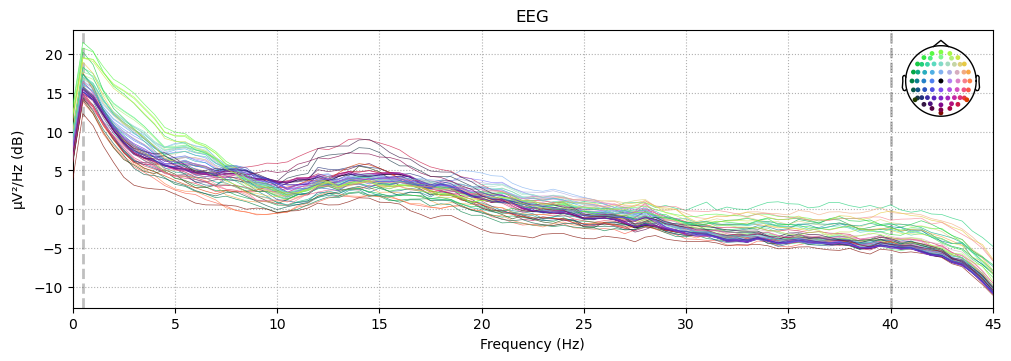

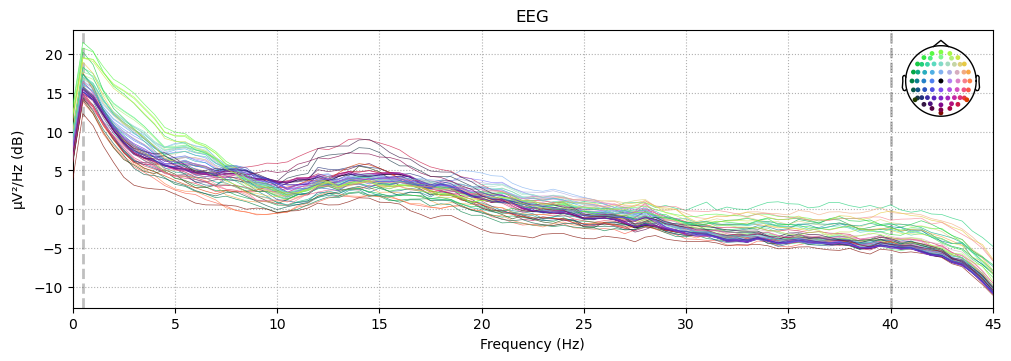

In [3]:
raw = raw.set_montage("biosemi64", on_missing="ignore")

raw.compute_psd(fmax=45).plot(picks="eeg")

## 2.2. Creando epocas de EOG

En un primer momento vamos a ir creando *épocas* es decir, períodos de tiempo que circunscriban a los movimientos oculares.


Using EOG channels: EXG3, EXG4, EXG5
EOG channel index for this subject is: [66 67 68]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG3 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 344 significant peaks
Number of EOG events detected: 344
Not setting metadata
344 matching events found
No baseline correction applied
Using data from preloaded Raw for 344 events and 1025 original time points ...
0 bad epochs dropped
Applyi

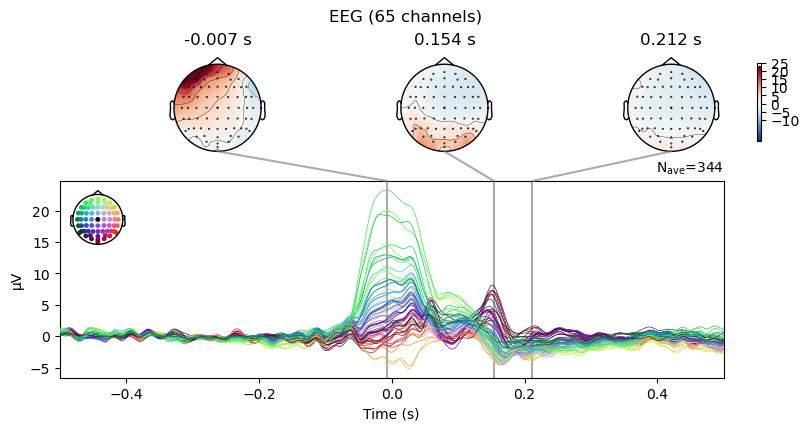

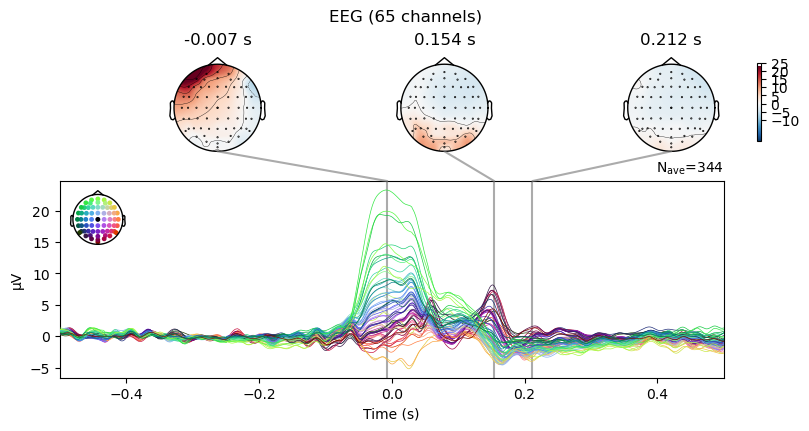

In [4]:
eog_evoked = create_eog_epochs(raw, reject_by_annotation=True).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

Ahora implementaremos un modelo estadístico para identificar estadísticamente a los movimientos oculares.

In [17]:
ica = ICA(n_components=30, max_iter="auto", random_state=97)
ica.fit(raw, reject_by_annotation=True,  )
ica

Fitting ICA to data using 65 channels (please be patient, this may take a while)
Selecting by number: 30 components


c:\Users\slipina\AppData\Local\anaconda3\envs\mne\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 1808.3s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,1000 iterations on raw data (728741 samples)
ICA components,30
Available PCA components,65
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=35, n_times=728741
    Range : 0 ... 728740 =      0.000 ...   711.660 secs
Ready.


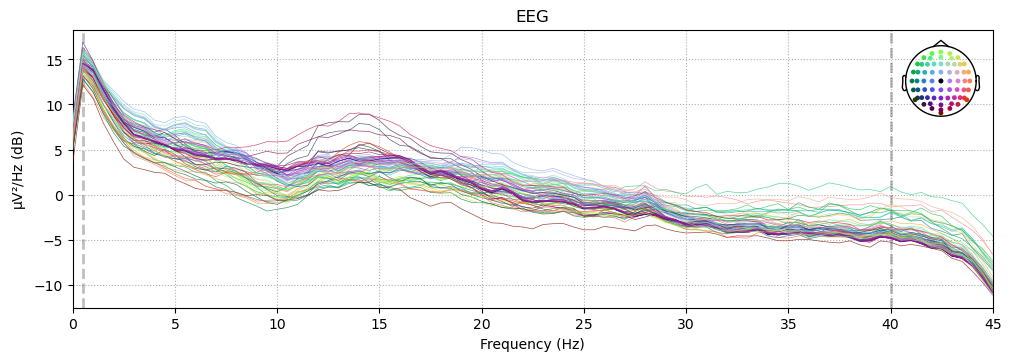

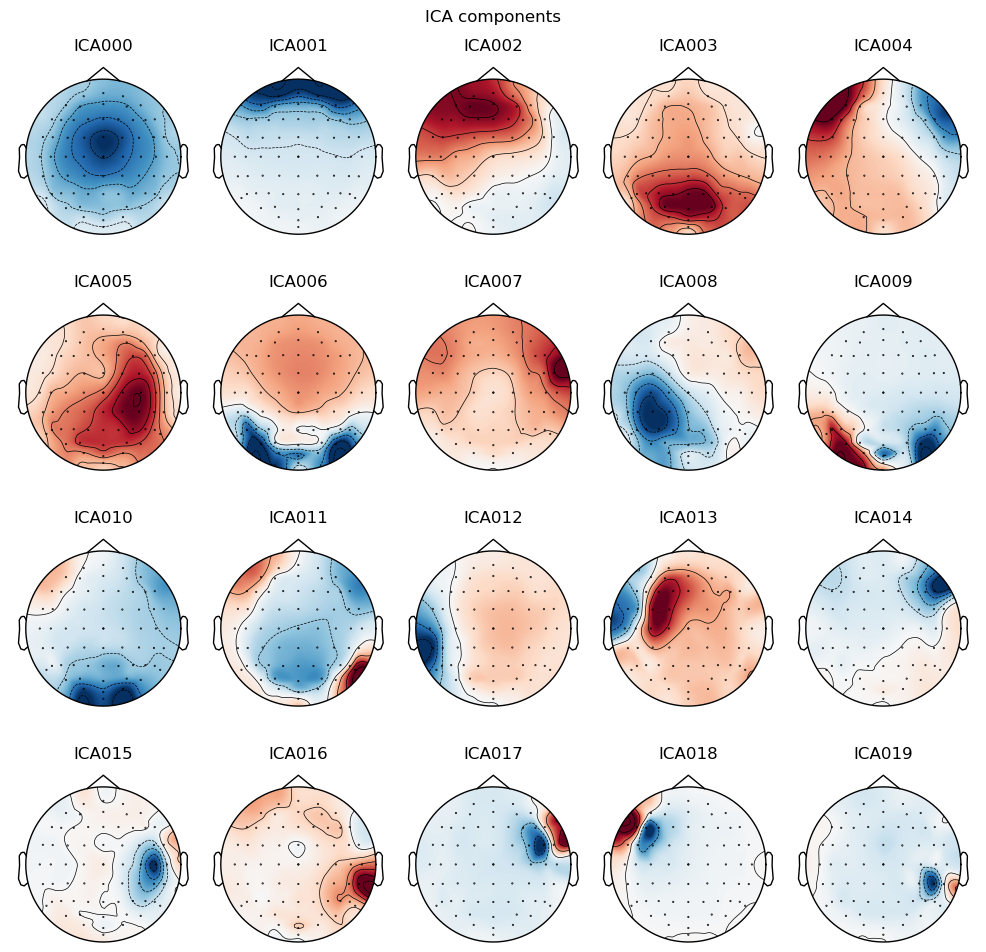

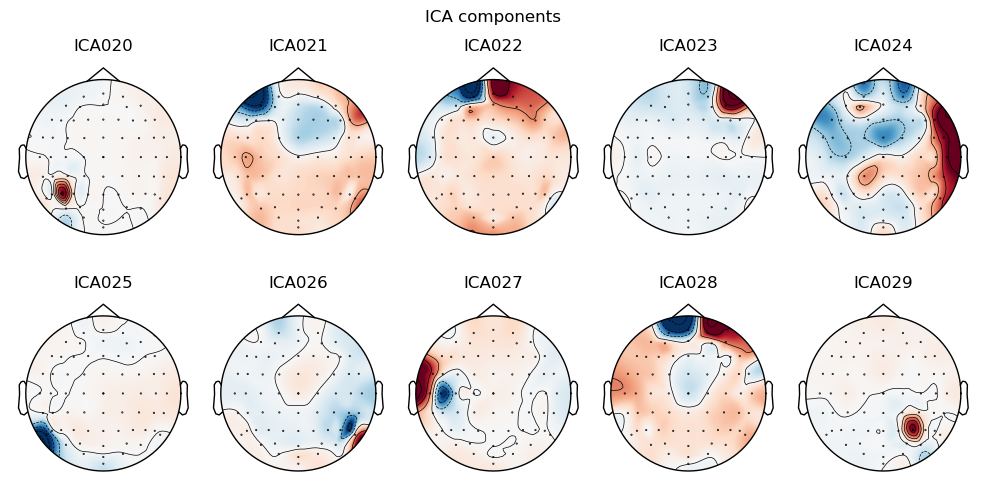

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 10 Axes>]

In [18]:
#raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)


ica.plot_components()

In [19]:
explained_var_ratio = ica.get_explained_variance_ratio(
    raw, components=[1,4], ch_type="eeg"
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by selected component(s): "
    f"{ratio_percent}%"
)

Fraction of variance in EEG signal explained by selected component(s): 30%


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 65 PCA components


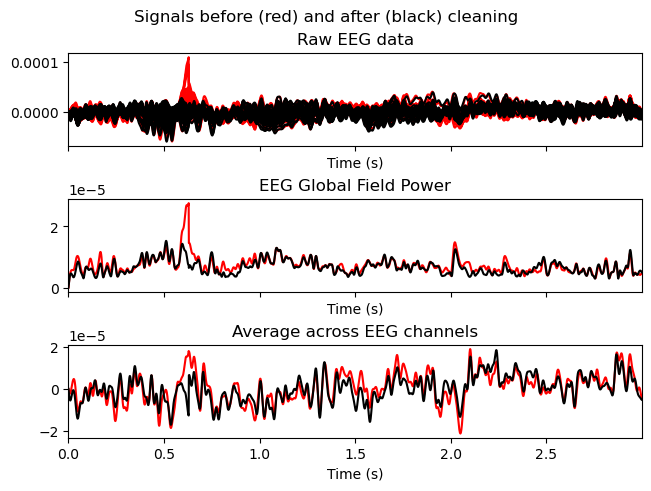

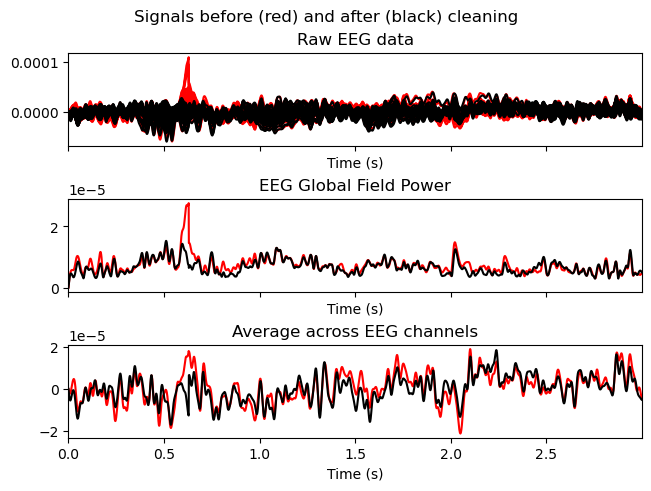

In [20]:
# blinks
ica.plot_overlay(raw, exclude=[1,3])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
355 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
355 matching events found
No baseline correction applied
0 projection items activated


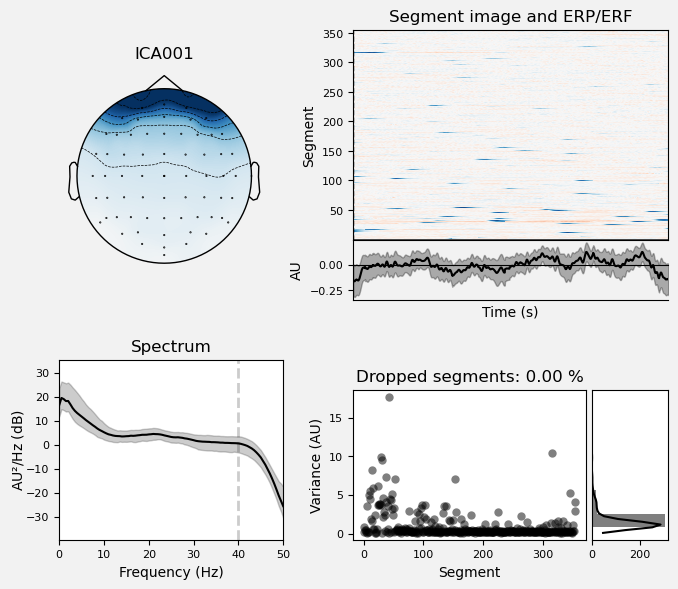

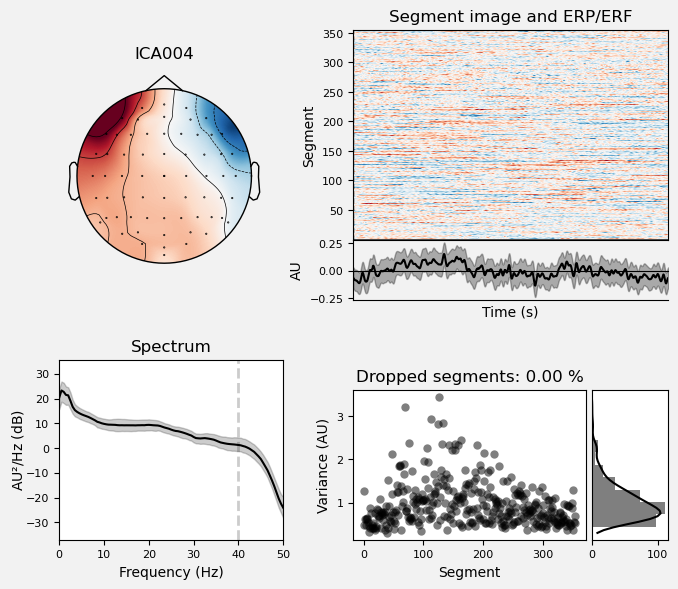

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [22]:
ica.plot_properties(raw, picks=[1,4])

In [24]:
ica.exclude = [1,4]


ica_raw = raw.copy()
ica.apply(ica_raw)



Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 65 PCA components


<Raw | SAAV0009_TOL_REF_FILT_CLEAN.fif, 73 x 728741 (711.7 s), ~406.0 MB, data loaded>

## 2.1. Inspección posterior

Volvemos a graficar el espectro. Ahora para ver las diferencias con el anterior

Effective window size : 2.000 (s)


c:\Users\slipina\AppData\Local\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


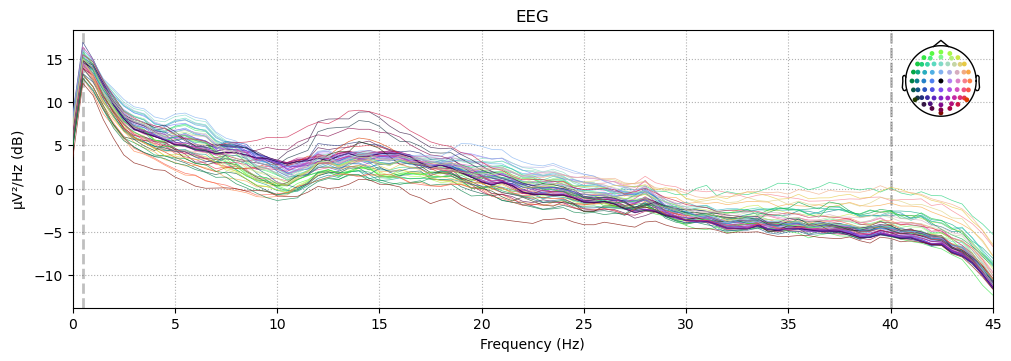

In [25]:
ica_raw.compute_psd(fmax=45, reject_by_annotation=True).plot(picks="data", exclude="bads")

# 4. Guardar datos limpios

In [26]:
ica_raw.save(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT_CLEAN_ICA.fif"), overwrite=True)


Overwriting existing file.
Writing e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0009_TOL_REF_FILT_CLEAN_ICA.fif


C:\Users\slipina\AppData\Local\Temp\ipykernel_8688\1804751308.py:1: RuntimeWarning: This filename (e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0009_TOL_REF_FILT_CLEAN_ICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ica_raw.save(("../data/" + task + "/preprocessing/" + subject_id + "_" + task +"_REF_FILT_CLEAN_ICA.fif"), overwrite=True)


Closing e:\Procesamiento EEG\scripts\..\data\TOL\preprocessing\SAAV0009_TOL_REF_FILT_CLEAN_ICA.fif
[done]
